In [14]:
import numpy as np
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

# 变量定义
# 定义质量变量
M1 = 10 * M_sun
M2 = 12 * M_sun
M = (M1 + M2)
v = M1 * M2 / M ** 2 # 质量比
M_c = v ** (3 / 5) * M  # 啁啾质量
r = 1e8 * pc # 引力波源到观测者的距离  100Mpc
t_c = 0 # 合并时间
phi_c = 0 # 合并时刻的相位
t = np.linspace(-10,0,1000)

# 定义引力波信号函数
def generate_h_t(t,M_c,r,phi_c):
    theta_t= c**3 *(t_c - t) / (5 * G * M_c)
    h = G * M_c /(c ** 2 * r) * theta_t**(-1/4)*np.cos(2*phi_c - 2*theta_t**(5/8))
    return h

h = generate_h_t(t,M_c,r,phi_c)

print(h)
print(np.fft.fft(h))

[ 3.09184896e-22  2.32145184e-22 -5.04332738e-23 -2.88552021e-22
 -2.71086803e-22 -1.31601177e-23  2.56641127e-22  2.98693942e-22
  7.52911435e-23 -2.15247210e-22 -3.14420748e-22 -1.33619581e-22
  1.66413879e-22  3.18245030e-22  1.86141406e-22 -1.12318891e-22
 -3.10614776e-22 -2.31239313e-22  5.51677057e-23  2.92379635e-22
  2.67709156e-22  2.90081259e-24 -2.64712898e-22 -2.94764465e-22
 -5.98936784e-23  2.29029131e-22  3.12021985e-22  1.14026451e-22
 -1.86902006e-22 -3.19471694e-22 -1.63768764e-22  1.39986147e-22
  3.17434998e-22  2.07873165e-22 -8.99459700e-23 -3.06514753e-22
 -2.45388440e-22  3.83936915e-23  2.87540597e-22  2.75659187e-22
  1.31621586e-23 -2.61512702e-22 -2.98313747e-22 -6.33570730e-23
  2.29546633e-22  3.13242800e-22  1.10999758e-22 -1.92821464e-22
 -3.20570991e-22 -1.55090688e-22  1.52532828e-22  3.20623841e-22
  1.94830938e-22 -1.09852029e-22 -3.13892055e-22 -2.29622467e-22
  6.58919157e-23  3.00995059e-22  2.59061223e-22 -2.16797622e-23
 -2.82645331e-22 -2.82924

/tmp/ipykernel_3269/1270788086.py:22: RuntimeWarning: divide by zero encountered in power
  h = G * M_c /(c ** 2 * r) * theta_t**(-1/4)*np.cos(2*phi_c - 2*theta_t**(5/8))


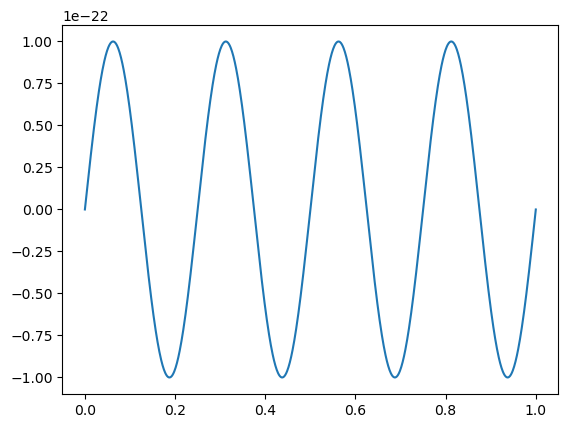

/tmp/ipykernel_3269/3190086034.py:24: RuntimeWarning: invalid value encountered in multiply
  signal_lens_f = signal_f * F_geo
/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


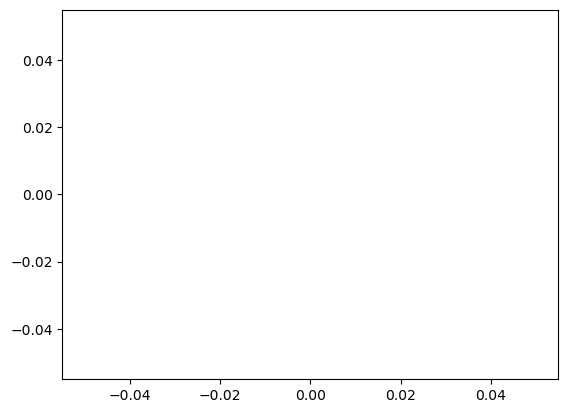

In [15]:
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(0, 1, 1000)
f = 4
signal = np.sin(2 * np.pi * f * t) * 1e-22

plt.plot(t, signal)
plt.show()
# print(signal)
# signal_fft = np.fft.fft(signal)
signal_f = np.fft.fft(h)
freqs = np.fft.fftfreq(len(h), t[1] - t[0])
Mlz = 100 * M_sun
omega = 2 * np.pi * freqs
# 两个无量纲参数，数值选取为论文中参数
w = 4 *Mlz * omega
y = 0.1
# 定义光学极限的透镜化
def generate_f_geo(w,y):
    F_geo = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)
    return F_geo

F_geo = generate_f_geo(w,y)
signal_lens_f = signal_f * F_geo
# signal_lens_f = signal_fft * F_geo
signal_lens_t = np.fft.ifft(signal_lens_f)

plt.plot(t, signal_lens_t)
plt.show()
